# Base Model HMM

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from hmmlearn import hmm

* first we set the global variables.

In [2]:
# Hidden Markov Model Modifiable Parameters
hidden_states = 3;
em_iterations = 100;

* then we read the data and dealete the unwanted data

In [3]:
df = pd.read_csv('data/SPY.csv')

df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)

* Here is our remaining DF

In [4]:
df

,Date,Close
0,1993-01-29,43.937500
1,1993-02-01,44.250000
2,1993-02-02,44.343750
3,1993-02-03,44.812500
4,1993-02-04,45.000000
...,...,...
7187,2021-08-13,445.920013
7188,2021-08-16,446.970001
7189,2021-08-17,444.040009
7190,2021-08-18,439.179993


* Now lest set the MA and then Volatility fo some number of days

In [5]:
yearly_adjust = np.sqrt(252)
hist_periods = [10, 30, 60, 120]
for period in hist_periods:
    df[f'MA_{period}_days'] = pd.Series(np.log(df['Close'] / df['Close'].shift(1))).rolling(period).std() * yearly_adjust
    df[f'hist_vol_{period}_days'] = pd.Series(np.log(df['Close'] / df['Close'].shift(1))).rolling(period).std() * yearly_adjust

In [6]:
# Return is the single-day percentage return
Return = []

# Filling in data for return, moving average, and volatility
for ind in df.index: 
    if ind >= 10:
        prev_close = df['Close'][ind-1];
        head_close = df['Close'][ind];
        Return.append(((head_close-prev_close)/prev_close)*100);
    else:
        Return.append(0);

df["Return"] = Return

In [7]:
df.fillna(0,inplace=True)

* This is our final DF with all moving average and the Return values

In [8]:
df

,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return
0,1993-01-29,43.937500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1993-02-01,44.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1993-02-02,44.343750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1993-02-03,44.812500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1993-02-04,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
7187,2021-08-13,445.920013,0.060217,0.060217,0.099337,0.099337,0.093842,0.093842,0.125438,0.125438,0.181984
7188,2021-08-16,446.970001,0.056429,0.056429,0.097529,0.097529,0.091833,0.091833,0.124633,0.124633,0.235466
7189,2021-08-17,444.040009,0.060805,0.060805,0.099675,0.099675,0.093130,0.093130,0.119485,0.119485,-0.655523
7190,2021-08-18,439.179993,0.080787,0.080787,0.105031,0.105031,0.094463,0.094463,0.120444,0.120444,-1.094500


In [9]:
# now we mark the test train randomly

# first we set a global var for year training days
year = 252

# we will set the start data 10 years + all nulls from MA
start_train_idx = 121 + 10*year

# stop for 2 years prior to data ends
stop_train_idx = df.shape[0]- 2*year

# and end index for the ending
end_test_idx = df.shape[0]

* divide the data

In [10]:
train = pd.DataFrame(df, index = range(start_train_idx, stop_train_idx)).reset_index(drop=True)
test = pd.DataFrame(df, index = range(stop_train_idx+1, end_test_idx)).reset_index(drop=True)

* see the shapes

In [11]:
train.shape, test.shape

((4047, 11), (503, 11))

* Create the model

In [12]:
model = hmm.GaussianHMM(n_components = hidden_states, covariance_type="full", n_iter = em_iterations);

* we will set the Data to be Fitted on the Volatility and the return.

In [13]:
obs = list(zip(train["hist_vol_10_days"], train["Return"]))

* Fitting the model and obtaining predictions

In [14]:
model.fit(obs)
predictions = model.predict(obs)

* now we see the predictions

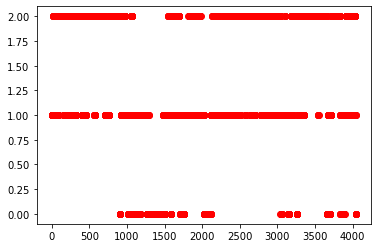

In [15]:
plt.plot(predictions, 'ro');

* and lets plot the state with regards to the closing 

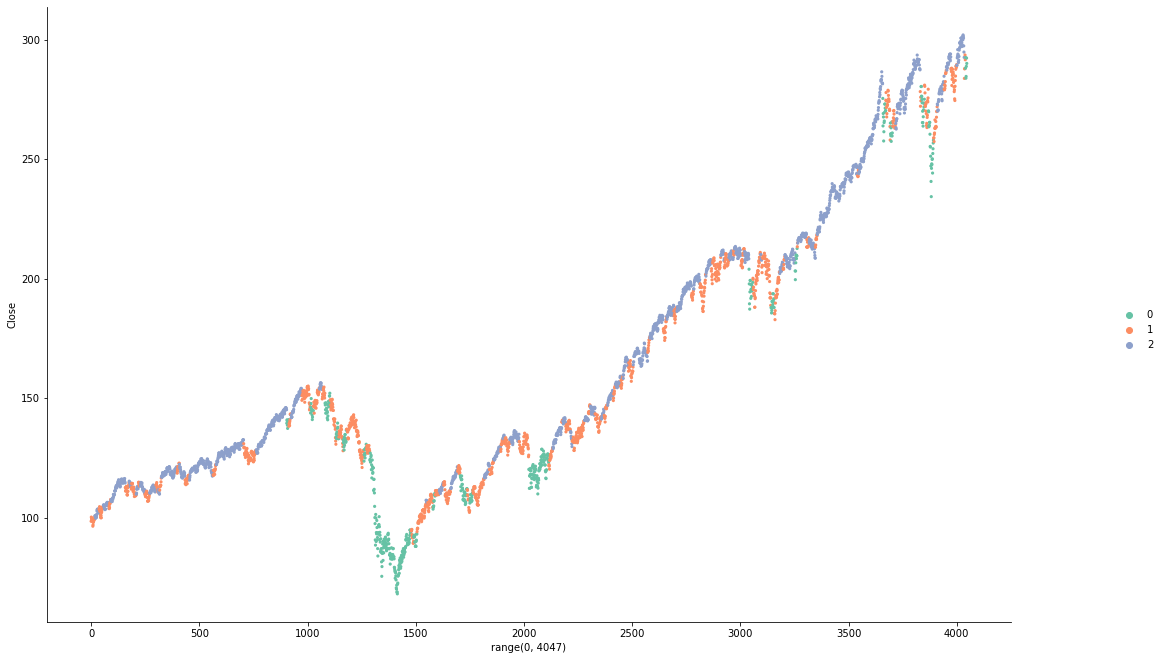

In [16]:
plot = sns.relplot(x=range(0,train.shape[0]), y="Close", data=train, hue=predictions, 
            linewidth = 0, palette="Set2", s = 10);
plot.fig.set_size_inches(18,10)

In [17]:
print("Model Score: {0}".format(model.score(obs)));

Model Score: 2685.7844471949293


* we can see 0 is the "loser state" we will choose the other ones

In [18]:
ret_lst = []
date_lst = []
for idx, prediction in enumerate(predictions):
    if prediction != 0:
        ret = train["Return"][idx]
        ret_lst.append(ret)
        date = train["Date"][idx]
        date_lst.append(date)
        
    

In [19]:
hmm_train_df = pd.DataFrame({
                            "Date" : date_lst,
                            "Return Percent" : ret_lst})

we will create only a winner state DF

In [20]:
hmm_train_df

,Date,Return Percent
0,2003-07-24,-0.755744
1,2003-07-25,1.766682
2,2003-07-28,-0.369153
3,2003-07-29,-0.460644
4,2003-07-30,-0.241447
...,...,...
3483,2019-08-05,-3.007309
3484,2019-08-06,1.402291
3485,2019-08-07,0.059073
3486,2019-08-08,1.962008


* Now we will set a 100 Dollars in the starting day and see the outcome according to the model and just leave our monney and not take it out.

In [21]:
amount = 100
ret_summed = []
for i in range(hmm_train_df.shape[0]):    
    amount = amount * (100 + hmm_train_df["Return Percent"][i])/100
    ret_summed.append(amount)
        

In [22]:
amount = 100
ret_summed_all = []
for i in range(train.shape[0]):    
    amount = amount * (100 + train["Return"][i])/100
    ret_summed_all.append(amount)

* With Model prediction

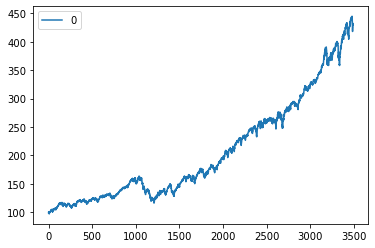

In [23]:
pd.DataFrame(np.array(ret_summed)).plot()

* Without Model prediction

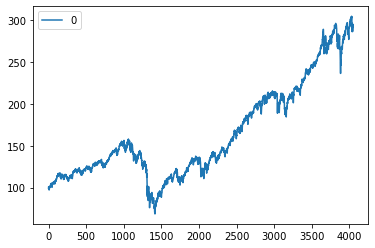

In [24]:
pd.DataFrame(np.array(ret_summed_all)).plot()

* We can see the prediction went well.

## Now lets test the model on the train data

In [25]:
obs = list(zip(test["hist_vol_10_days"], test["Return"]))

In [26]:
predictions = model.predict(obs)

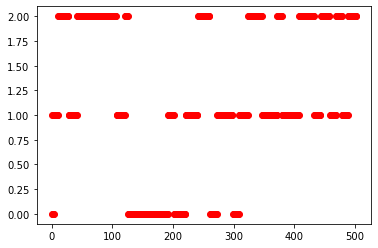

In [27]:
plt.plot(predictions, 'ro');

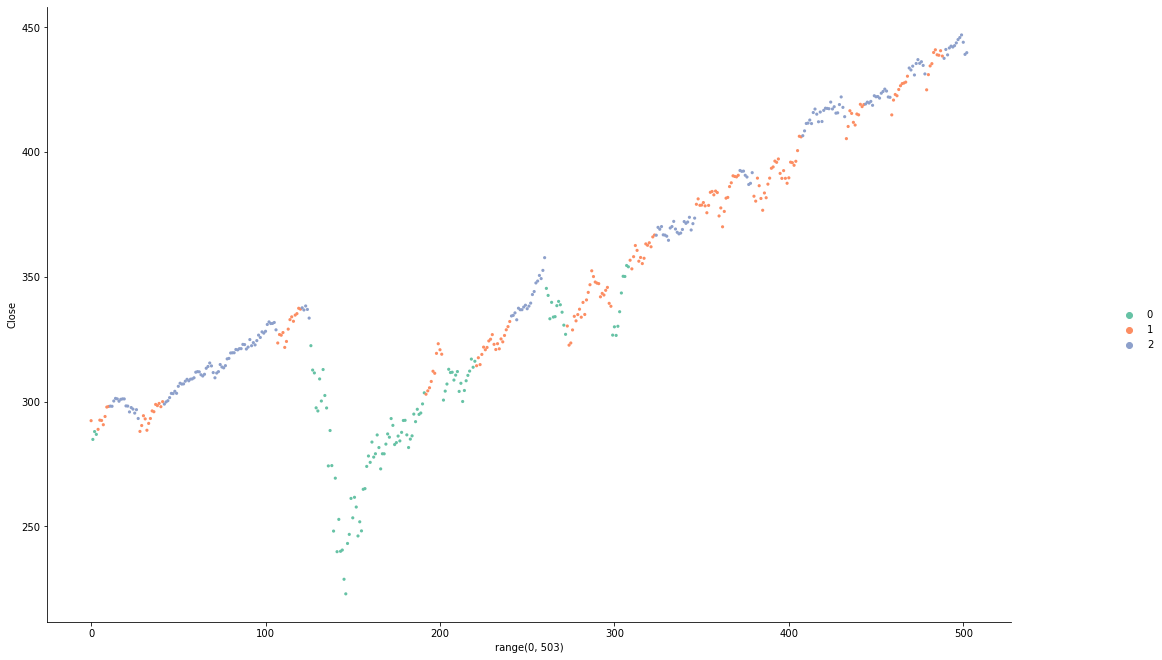

In [28]:
plot = sns.relplot(x=range(0,test.shape[0]), y="Close", data=test, hue=predictions, 
            linewidth = 0, palette="Set2", s = 10);
plot.fig.set_size_inches(18,10)

In [29]:
print("Model Score: {0}".format(model.score(obs)));

Model Score: 14.26038856509083


In [30]:
ret_lst = []
date_lst = []
for idx, prediction in enumerate(predictions):
    if prediction != 0:
        ret = test["Return"][idx]
        ret_lst.append(ret)
        date = test["Date"][idx]
        date_lst.append(date)
        
    

In [31]:
hmm_test_df = pd.DataFrame({
                            "Date" : date_lst,
                            "Return Percent" : ret_lst})

In [32]:
amount = 100
ret_summed_test = []
for i in range(hmm_test_df.shape[0]):    
    amount = amount * (100 + hmm_test_df["Return Percent"][i])/100
    ret_summed_test.append(amount)
        

In [33]:
amount = 100
ret_summed_all_test = []
for i in range(test.shape[0]):    
    amount = amount * (100 + test["Return"][i])/100
    ret_summed_all_test.append(amount)

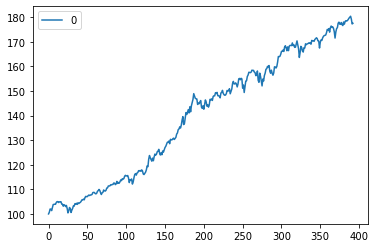

In [34]:
pd.DataFrame(np.array(ret_summed_test)).plot()

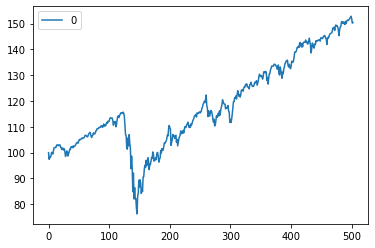

In [35]:
pd.DataFrame(np.array(ret_summed_all_test)).plot()

* we can see a great outcome for about 30 $